In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Reading and understanding the data

In [2]:
# Data has no missing values
bike = pd.read_csv("/Users/mannam.sriram/Documents/personal/EXPG/Linear Regression/BikeSharingAssignment/day.csv")
bike.info(verbose = True)
bike.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
#Converting the date into pandas DateTimeIndex
bike.dteday = pd.DatetimeIndex(bike.dteday)

In [4]:
numerical_columns = ["temp", "atemp", "hum", "windspeed"]
catagorical_columns = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit"]

## Step 2: Visualising the Data

/Users/mannam.sriram/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


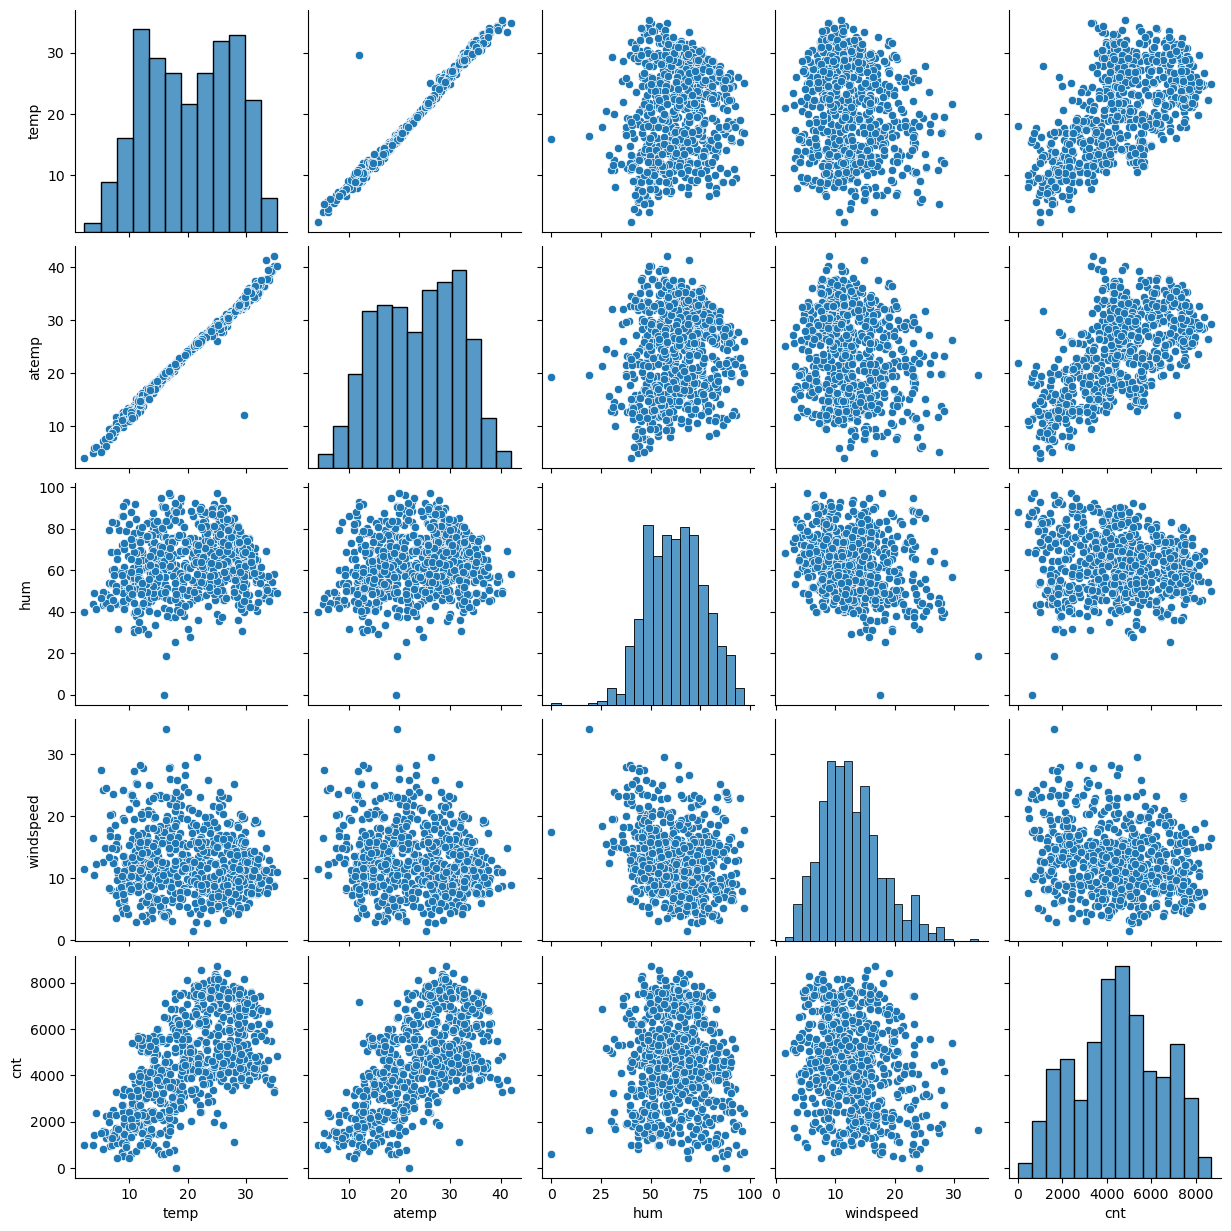

In [5]:
#pair plot on numerical coliumns against cnt
numerical_columns.append("cnt")
sns.pairplot(bike[numerical_columns])
plt.show()

## Observations
- atemp has the highest correlation with cnt
- humidity and windspeed has less correlation with cnt compared to atemp

<Figure size 2000x1200 with 0 Axes>

<Axes: >

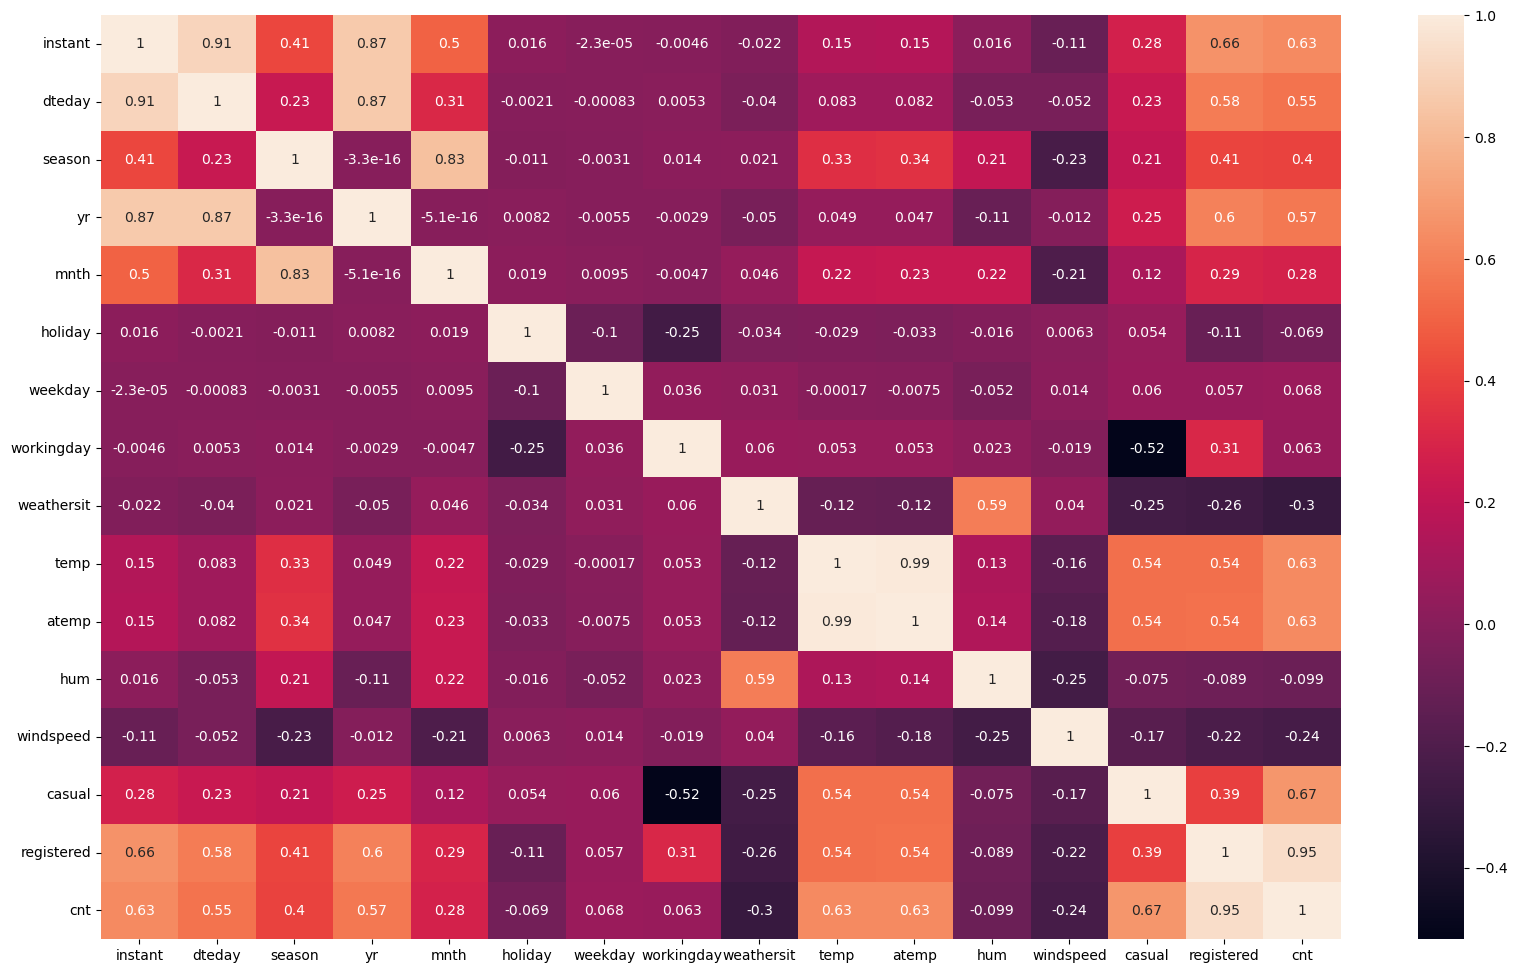

In [6]:
plt.figure(figsize=(20, 12))
sns.heatmap(bike.corr(), annot = True)
plt.show()

### Observations from Heat Map
- Season has a positive correlation to count
- month also has a positive correlation to count
- weather situation has slightly negative correlation
- tem has a positive correlation
- wind speed has slightly negative correlation'
- working day has negative correlation
- weekday has almost no correlation

## Step3: Data Preparation
- creating dummy variables for categorical variables
- Creating X and Y
- creating train test split

In [7]:
# create dummt variables for season (1:spring, 2:summer, 3:fall, 4:winter)
season = pd.get_dummies(bike['season'], prefix = "season", dtype=int)
season.rename(columns = {'season_1': 'spring', 'season_2': 'summer', 'season_3': "fall", 'season_4': "winter"}, inplace = True)
bike = pd.concat([bike, season], axis = 1)

#create dummy variables for mnth
month = pd.get_dummies(bike['mnth'], prefix = "month", dtype=int)
month.rename(columns = {'month_1': 'Jan', 'month_2': 'Feb', 'month_3': "Mar", 'month_4': "Apr", 
                         'month_5': "May", 'month_6': "Jun", 'month_7': "Jul", 'month_8': "Aug",
                        'month_9': "Sep", 'month_10': "Oct", 'month_11': "Nov", 'month_12': "Dec"}, inplace = True)
bike  = pd.concat([bike, month], axis = 1)

#convert weather
#weathersit : 
#		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
#		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
#		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
#		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
weather = pd.get_dummies(bike['weathersit'], prefix = "weather", dtype=int)
weather.rename(columns = {'weather_1': 'weather_Clear', 'weather_2': 'weather_mist', 
                        'weather_3': "weather_light_snow", 'weather_4': "weather_heavy_rain"}, inplace = True)
bike = pd.concat([bike, weather], axis = 1)
bike.head()
bike.columns

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,weather_Clear,weather_mist,weather_light_snow
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,...,0,0,0,0,0,0,0,0,1,0
1,2,2018-02-01,1,0,1,0,0,0,2,14.902598,...,0,0,0,0,0,0,0,0,1,0
2,3,2018-03-01,1,0,1,0,1,1,1,8.050924,...,0,0,0,0,0,0,0,1,0,0
3,4,2018-04-01,1,0,1,0,2,1,1,8.200000,...,0,0,0,0,0,0,0,1,0,0
4,5,2018-05-01,1,0,1,0,3,1,1,9.305237,...,0,0,0,0,0,0,0,1,0,0


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'spring', 'summer', 'fall', 'winter',
       'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'weather_Clear', 'weather_mist', 'weather_light_snow'],
      dtype='object')

<Figure size 3000x3000 with 0 Axes>

<Axes: >

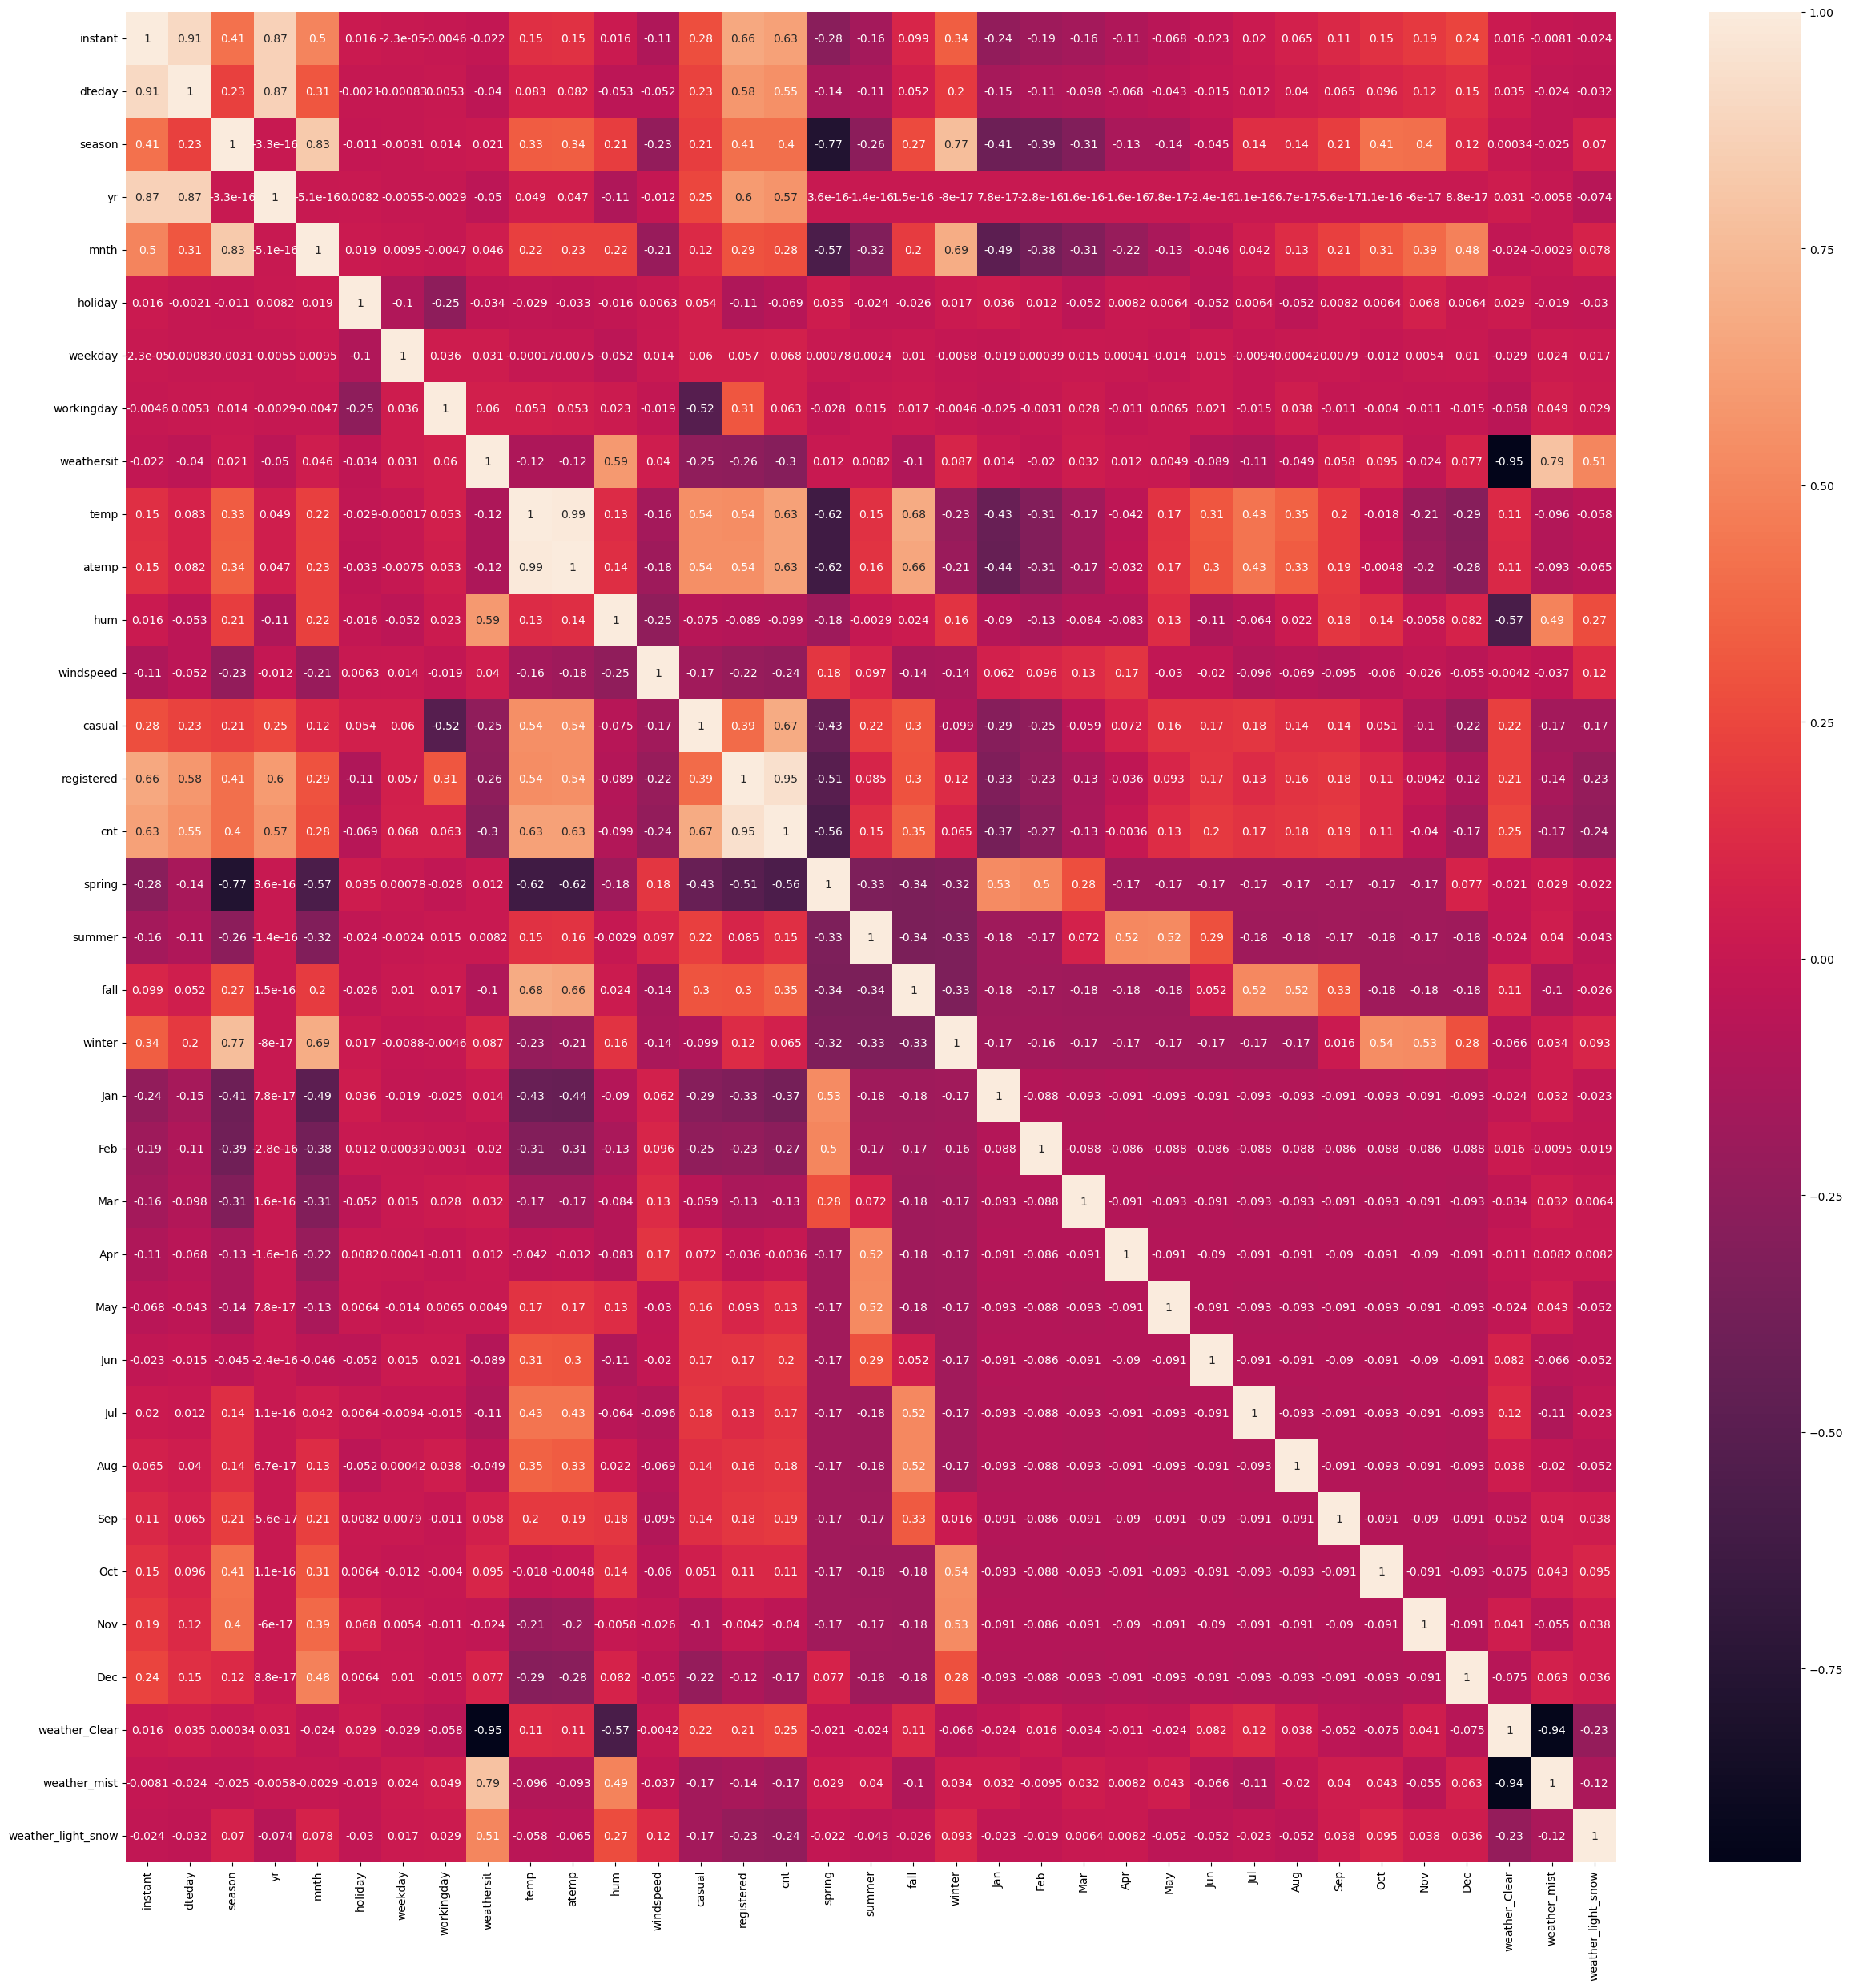

In [8]:
plt.figure(figsize=(30, 30))
sns.heatmap(bike.corr(), annot = True)
plt.show()

## Observations
- summer and spring has negative correlation
- winter has postive correlation of 0.34
- Jan to June has negative correlation
- Dec has highest correlation 0.24
- light snow situation has negative correlation

In [9]:
## select the requuired columns
#'season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'

# dteday and yr are higtly correlated with value 0.87 so we can keep yr
# we have not removed the first columns when we did pd.get_dummies so select n-1 columns here
# temp and atemp are positively correlated 0.99 so we can keep only one
# weather_mist and weather_clear are highly negatively correlated with value -0.99 so we can keep one of them

interested_cols = ['summer', 'fall', 'winter', 
        "yr", 
        'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec', 
        "holiday", "weekday", "workingday", 
        'weather_Clear', 'weather_light_snow',
         'atemp', 'hum', 'windspeed', "cnt"]

bike_sel = bike[interested_cols]
bike_sel.head()
bike_sel.shape

,summer,fall,winter,yr,Feb,Mar,Apr,May,Jun,Jul,...,Dec,holiday,weekday,workingday,weather_Clear,weather_light_snow,atemp,hum,windspeed,cnt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,18.18125,80.5833,10.749882,985
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17.68695,69.6087,16.652113,801
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,9.47025,43.7273,16.636703,1349
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,1,0,10.60610,59.0435,10.739832,1562
4,0,0,0,0,0,0,0,0,0,0,...,0,0,3,1,1,0,11.46350,43.6957,12.522300,1600


(730, 24)

### Creating train and test split

In [10]:
#create test train split
bike_train, bike_test =  train_test_split(bike_sel, train_size = 0.7, random_state = 100)
bike_train.shape
bike_test.shape

(510, 24)

(220, 24)

## Normalize numerical columns using min max scaling on train data

In [11]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
cols_to_be_scaled = ['atemp', 'hum', 'windspeed']
bike_train[cols_to_be_scaled] = min_max_scaler.fit_transform(bike_train[cols_to_be_scaled])
bike_train[cols_to_be_scaled].head()

,atemp,hum,windspeed
576,0.766351,0.725633,0.264686
426,0.438975,0.640189,0.255342
728,0.200348,0.498067,0.663106
482,0.391735,0.504508,0.188475
111,0.318819,0.751824,0.380981


### Dividing into X and Y sets for the model building

In [12]:
y_train = bike_train.pop('cnt')
X_train = bike_train

## Model Creation

In [13]:
cols_to_be_dropped = []

def calculate_vif_score(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [14]:
#Lets use backward approach, builda model with all the features
X_train_all = sm.add_constant(X_train)

# Create a first fitted model
lr_all = sm.OLS(y_train, X_train_all).fit()
lr_all.summary()

#calculate VIF
calculate_vif_score(X_train_all)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     119.7
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          1.41e-183
Time:                        21:39:43   Log-Likelihood:                -4103.2
No. Observations:                 510   AIC:                             8254.
Df Residuals:                     486   BIC:                             8356.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1041.1597    303.977      3.425      0.001     443.888    1638.431
summer               754.5982    205.952      3.664      0.000     349.932    1159.264
fall                 443.6596    260.794      1.701      0.090     -68.763     956.082
winter              1338.7433    226.291      5.916      0.000     894.114    1783.373
yr                  2038.5864     70.134     29.067      0.000    1900.782    2176.390
Feb                  287.7175    179.594      1.602      0.110     -65.159     640.594
Mar                  635.0742    193.331      3.285      0.001     255.206    1014.943
Apr                  641.6929    291.020      2.205      0.028      69.881    1213.505
May                  956.0984    308.202      3.102      0.002     350.526    1561.671
Jun                  858.3635    326.206      2.631      0.009     217.416    1499.311
Jul                  520.1285    371.583      1.400      0.162    -209.979    1250.236
Aug                 1012.8408    352.018      2.877      0.004     321.176    1704.505
Sep                 1476.3897    320.125      4.612      0.000     847.391    2105.389
Oct                  702.5593    299.035      2.349      0.019     114.999    1290.120
Nov                  233.2431    285.863      0.816      0.415    -328.438     794.924
Dec                  175.3045    231.167      0.758      0.449    -278.905     629.514
holiday             -520.4024    229.207     -2.270      0.024    -970.762     -70.043
weekday               70.1314     17.317      4.050      0.000      36.107     104.156
workingday           154.9480     76.002      2.039      0.042       5.615     304.281
weather_Clear        529.8795     90.758      5.838      0.000     351.553     708.206
weather_light_snow -1660.0839    217.017     -7.650      0.000   -2086.491   -1233.677
atemp               3609.6123    392.325      9.201      0.000    2838.750    4380.475
hum                -1260.6328    336.122     -3.751      0.000   -1921.065    -600.200
windspeed          -1461.4008    224.751     -6.502      0.000   -1903.005   -1019.797
==============================================================================
Omnibus:                       85.830   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.231
Skew:                          -0.790   Prob(JB):                     5.11e-57
Kurtosis:                       6.115   Cond. No.                         97.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,78.82
2,fall,11.24
11,Aug,9.18
10,Jul,8.32
3,winter,8.13
1,summer,6.73
12,Sep,6.46
9,Jun,6.41
8,May,6.26
21,atemp,5.91


### observations
- Rwith all the variables R2_score is 0.86
- there are many variables with hight p-value and many variables with high VIF score
- Drop the columns with high p-value wihc is Dec and rebuild the model

In [15]:
#Model with Dec dropped
cols_to_be_dropped.append("Dec")
X_train_dec = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec = sm.OLS(y_train, X_train_dec).fit()
lr_dec.summary()

#calculate VIF
calculate_vif_score(X_train_dec)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.2
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          1.65e-184
Time:                        21:39:43   Log-Likelihood:                -4103.5
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     487   BIC:                             8350.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1065.8248    302.100      3.528      0.000     472.244    1659.405
summer               784.1816    202.135      3.879      0.000     387.017    1181.347
fall                 507.8750    246.556      2.060      0.040      23.430     992.320
winter              1453.4205    168.272      8.637      0.000    1122.792    1784.049
yr                  2035.6612     69.998     29.082      0.000    1898.126    2173.196
Feb                  239.9606    168.117      1.427      0.154     -90.364     570.286
Mar                  571.1898    173.937      3.284      0.001     229.431     912.949
Apr                  554.9258    267.468      2.075      0.039      29.393    1080.459
May                  863.4995    282.858      3.053      0.002     307.727    1419.272
Jun                  748.8361    292.362      2.561      0.011     174.389    1323.283
Jul                  384.6447    325.673      1.181      0.238    -255.253    1024.543
Aug                  880.7627    305.779      2.880      0.004     279.953    1481.572
Sep                 1336.7523    261.753      5.107      0.000     822.448    1851.057
Oct                  529.5724    193.274      2.740      0.006     149.819     909.326
Nov                   66.0348    181.859      0.363      0.717    -291.291     423.361
holiday             -517.8215    229.082     -2.260      0.024    -967.933     -67.710
weekday               70.5683     17.300      4.079      0.000      36.577     104.559
workingday           153.0589     75.928      2.016      0.044       3.872     302.245
weather_Clear        532.6681     90.644      5.876      0.000     354.567     710.770
weather_light_snow -1658.1461    216.907     -7.645      0.000   -2084.335   -1231.957
atemp               3655.5518    387.451      9.435      0.000    2894.271    4416.833
hum                -1252.5385    335.806     -3.730      0.000   -1912.347    -592.730
windspeed          -1448.7005    224.029     -6.467      0.000   -1888.882   -1008.519
==============================================================================
Omnibus:                       85.149   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.620
Skew:                          -0.784   Prob(JB):                     1.89e-56
Kurtosis:                       6.101   Cond. No.                         79.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,77.92
2,fall,10.05
11,Aug,6.93
1,summer,6.49
10,Jul,6.40
20,atemp,5.77
8,May,5.27
9,Jun,5.15
3,winter,4.50
7,Apr,4.41


### Observations
- R2-score is still 0.85
- Nov has hight p-value , drop the model and re build it

In [16]:
#Model with Nov dropped
cols_to_be_dropped.append("Nov")
X_train_dec_nov = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov = sm.OLS(y_train, X_train_dec_nov).fit()
lr_dec_nov.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.4
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          1.52e-185
Time:                        21:39:43   Log-Likelihood:                -4103.5
No. Observations:                 510   AIC:                             8251.
Df Residuals:                     488   BIC:                             8344.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1066.7821    301.820      3.534      0.000     473.755    1659.809
summer               793.2802    200.398      3.959      0.000     399.531    1187.029
fall                 526.6403    240.865      2.186      0.029      53.381     999.900
winter              1487.8577    138.876     10.714      0.000    1214.990    1760.726
yr                  2035.0625     69.916     29.107      0.000    1897.689    2172.436
Feb                  236.4897    167.696      1.410      0.159     -93.006     565.985
Mar                  563.1855    172.381      3.267      0.001     224.486     901.885
Apr                  539.1245    263.669      2.045      0.041      21.058    1057.191
May                  847.3618    279.096      3.036      0.003     298.984    1395.740
Jun                  726.8484    285.768      2.543      0.011     165.361    1288.336
Jul                  355.3862    315.267      1.127      0.260    -264.061     974.834
Aug                  853.0896    295.866      2.883      0.004     271.761    1434.418
Sep                 1306.8818    248.269      5.264      0.000     819.074    1794.690
Oct                  489.4926    158.513      3.088      0.002     178.041     800.944
holiday             -509.5889    227.754     -2.237      0.026    -957.089     -62.089
weekday               70.3805     17.276      4.074      0.000      36.435     104.326
workingday           152.9734     75.860      2.017      0.044       3.921     302.026
weather_Clear        531.9691     90.543      5.875      0.000     354.067     709.871
weather_light_snow -1655.3903    216.581     -7.643      0.000   -2080.937   -1229.844
atemp               3672.3154    384.348      9.555      0.000    2917.134    4427.496
hum                -1259.9877    334.881     -3.762      0.000   -1917.974    -602.002
windspeed          -1441.4052    222.927     -6.466      0.000   -1879.421   -1003.389
==============================================================================
Omnibus:                       84.314   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.072
Skew:                          -0.778   Prob(JB):                     1.11e-55
Kurtosis:                       6.081   Cond. No.                         76.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,77.91
2,fall,9.61
11,Aug,6.50
1,summer,6.39
10,Jul,6.00
19,atemp,5.69
8,May,5.14
9,Jun,4.93
7,Apr,4.30
12,Sep,3.90


### Observations
- R2-score is still 0.85
- Jul has hight p-value , drop the model and re build it

In [17]:
#Model with Nov dropped
cols_to_be_dropped.append("Jul")
X_train_dec_nov_jul = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul = sm.OLS(y_train, X_train_dec_nov_jul).fit()
lr_dec_nov_jul.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     137.9
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          2.40e-186
Time:                        21:39:43   Log-Likelihood:                -4104.2
No. Observations:                 510   AIC:                             8250.
Df Residuals:                     489   BIC:                             8339.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1072.8311    301.856      3.554      0.000     479.737    1665.925
summer               868.0145    189.166      4.589      0.000     496.337    1239.692
fall                 675.8361    201.298      3.357      0.001     280.321    1071.351
winter              1460.6770    136.804     10.677      0.000    1191.880    1729.473
yr                  2031.5027     69.864     29.078      0.000    1894.232    2168.773
Feb                  209.1085    165.973      1.260      0.208    -117.001     535.218
Mar                  479.9355    155.802      3.080      0.002     173.811     786.060
Apr                  388.0558    227.134      1.708      0.088     -58.224     834.335
May                  668.7328    229.811      2.910      0.004     217.194    1120.271
Jun                  492.4332    196.062      2.512      0.012     107.205     877.662
Aug                  570.1075    156.624      3.640      0.000     262.368     877.847
Sep                 1085.6099    152.051      7.140      0.000     786.856    1384.364
Oct                  439.6420    152.261      2.887      0.004     140.475     738.809
holiday             -537.4740    226.470     -2.373      0.018    -982.448     -92.500
weekday               70.1041     17.279      4.057      0.000      36.153     104.055
workingday           147.8795     75.746      1.952      0.051      -0.948     296.707
weather_Clear        525.2186     90.370      5.812      0.000     347.658     702.779
weather_light_snow -1649.2701    216.573     -7.615      0.000   -2074.799   -1223.741
atemp               3907.0477    323.141     12.091      0.000    3272.132    4541.964
hum                -1313.9416    331.534     -3.963      0.000   -1965.349    -662.534
windspeed          -1442.4777    222.987     -6.469      0.000   -1880.609   -1004.347
==============================================================================
Omnibus:                       81.247   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.237
Skew:                          -0.755   Prob(JB):                     1.12e-52
Kurtosis:                       5.996   Cond. No.                         52.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,77.89
2,fall,6.71
1,summer,5.69
18,atemp,4.02
8,May,3.49
7,Apr,3.19
3,winter,2.98
9,Jun,2.32
19,hum,1.99
6,Mar,1.83


### Observations
- R2-score is still 0.85
- Feb has hight p-value , drop the model and re build it

In [18]:
#Model with Feb dropped
cols_to_be_dropped.append("Feb")
X_train_dec_nov_jul_feb = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul_feb = sm.OLS(y_train, X_train_dec_nov_jul_feb).fit()
lr_dec_nov_jul_feb.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul_feb)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     144.9
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          4.32e-187
Time:                        21:39:43   Log-Likelihood:                -4105.0
No. Observations:                 510   AIC:                             8250.
Df Residuals:                     490   BIC:                             8335.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1153.9252    295.090      3.910      0.000     574.127    1733.723
summer               837.9012    187.762      4.463      0.000     468.983    1206.819
fall                 602.5844    192.834      3.125      0.002     223.701     981.468
winter              1387.7120    124.015     11.190      0.000    1144.045    1631.379
yr                  2030.6317     69.902     29.050      0.000    1893.286    2167.977
Mar                  413.6623    146.742      2.819      0.005     125.341     701.983
Apr                  338.1528    223.788      1.511      0.131    -101.550     777.855
May                  621.7991    226.907      2.740      0.006     175.968    1067.630
Jun                  456.6110    194.106      2.352      0.019      75.228     837.994
Aug                  564.2390    156.649      3.602      0.000     256.453     872.025
Sep                 1081.8938    152.113      7.112      0.000     783.019    1380.769
Oct                  436.5764    152.333      2.866      0.004     137.270     735.883
holiday             -534.3624    226.592     -2.358      0.019    -979.574     -89.151
weekday               68.9939     17.267      3.996      0.000      35.067     102.921
workingday           149.9259     75.774      1.979      0.048       1.044     298.808
weather_Clear        523.2654     90.410      5.788      0.000     345.625     700.905
weather_light_snow -1636.7389    216.474     -7.561      0.000   -2062.071   -1211.407
atemp               3926.9867    322.946     12.160      0.000    3292.456    4561.517
hum                -1340.4963    331.062     -4.049      0.000   -1990.973    -690.020
windspeed          -1423.8377    222.629     -6.396      0.000   -1861.263    -986.413
==============================================================================
Omnibus:                       81.577   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.100
Skew:                          -0.760   Prob(JB):                     1.20e-52
Kurtosis:                       5.990   Cond. No.                         51.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,74.35
2,fall,6.15
1,summer,5.60
17,atemp,4.01
7,May,3.39
6,Apr,3.09
3,winter,2.44
8,Jun,2.27
18,hum,1.99
9,Aug,1.82


### Observations
- R2-score is still 0.849
- Apr has hight p-value , drop the model and re build it

In [19]:
#Model with Apr dropped
cols_to_be_dropped.append("Apr")
X_train_dec_nov_jul_feb_apr = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul_feb_apr = sm.OLS(y_train, X_train_dec_nov_jul_feb_apr).fit()
lr_dec_nov_jul_feb_apr.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul_feb_apr)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     152.4
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          1.07e-187
Time:                        21:39:43   Log-Likelihood:                -4106.2
No. Observations:                 510   AIC:                             8250.
Df Residuals:                     491   BIC:                             8331.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1184.7411    294.769      4.019      0.000     605.577    1763.905
summer              1036.5359    134.242      7.721      0.000     772.775    1300.296
fall                 597.4483    193.056      3.095      0.002     218.131     976.766
winter              1364.2628    123.201     11.073      0.000    1122.196    1606.329
yr                  2032.8342     69.978     29.049      0.000    1895.340    2170.328
Mar                  309.1992    129.605      2.386      0.017      54.550     563.849
May                  387.4033    165.818      2.336      0.020      61.602     713.205
Jun                  285.9636    158.077      1.809      0.071     -24.627     596.554
Aug                  527.3409    154.936      3.404      0.001     222.922     831.760
Sep                 1055.5996    151.312      6.976      0.000     758.300    1352.899
Oct                  429.5754    152.461      2.818      0.005     130.018     729.132
holiday             -539.9509    226.858     -2.380      0.018    -985.682     -94.219
weekday               68.4748     17.286      3.961      0.000      34.510     102.439
workingday           151.2519     75.868      1.994      0.047       2.186     300.318
weather_Clear        521.2774     90.519      5.759      0.000     343.425     699.130
weather_light_snow -1633.0106    216.743     -7.534      0.000   -2058.868   -1207.153
atemp               3972.5870    321.953     12.339      0.000    3340.011    4605.163
hum                -1384.3950    330.216     -4.192      0.000   -2033.205    -735.585
windspeed          -1395.6480    222.136     -6.283      0.000   -1832.102    -959.194
==============================================================================
Omnibus:                       82.879   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.197
Skew:                          -0.772   Prob(JB):                     1.55e-53
Kurtosis:                       6.010   Cond. No.                         50.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,73.99
2,fall,6.15
16,atemp,3.97
1,summer,2.85
3,winter,2.40
17,hum,1.97
6,May,1.81
8,Aug,1.78
14,weather_Clear,1.63
10,Oct,1.53


### Observations
- R2-score is still 0.848
- Jun has hight p-value , drop the model and re build it

In [20]:
#Model with Apr dropped
cols_to_be_dropped.append("Jun")
X_train_dec_nov_jul_feb_apr_jun = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul_feb_apr_jun = sm.OLS(y_train, X_train_dec_nov_jul_feb_apr_jun).fit()
lr_dec_nov_jul_feb_apr_jun.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul_feb_apr_jun)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.4
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          4.21e-188
Time:                        21:39:43   Log-Likelihood:                -4107.9
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     492   BIC:                             8328.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1184.9391    295.449      4.011      0.000     604.442    1765.436
summer              1072.8350    133.041      8.064      0.000     811.437    1334.233
fall                 557.5269    192.233      2.900      0.004     179.829     935.225
winter              1336.4768    122.522     10.908      0.000    1095.746    1577.208
yr                  2025.9624     70.036     28.927      0.000    1888.355    2163.570
Mar                  261.5351    127.192      2.056      0.040      11.629     511.441
May                  274.3093    153.936      1.782      0.075     -28.144     576.763
Aug                  464.6691    151.361      3.070      0.002     167.275     762.063
Sep                 1009.1775    149.464      6.752      0.000     715.510    1302.844
Oct                  404.3345    152.172      2.657      0.008     105.348     703.321
holiday             -556.1005    227.205     -2.448      0.015   -1002.512    -109.689
weekday               68.5469     17.326      3.956      0.000      34.504     102.590
workingday           150.7017     76.042      1.982      0.048       1.294     300.109
weather_Clear        517.5660     90.704      5.706      0.000     339.350     695.782
weather_light_snow -1631.9508    217.242     -7.512      0.000   -2058.787   -1205.114
atemp               4169.4472    303.703     13.729      0.000    3572.731    4766.163
hum                -1430.9191    329.972     -4.336      0.000   -2079.247    -782.591
windspeed          -1421.3995    222.190     -6.397      0.000   -1857.959    -984.840
==============================================================================
Omnibus:                       81.443   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.327
Skew:                          -0.769   Prob(JB):                     5.86e-51
Kurtosis:                       5.919   Cond. No.                         50.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,73.99
2,fall,6.07
15,atemp,3.52
1,summer,2.79
3,winter,2.37
16,hum,1.96
7,Aug,1.69
13,weather_Clear,1.63
6,May,1.55
9,Oct,1.52


### Observations
- R2-score is still 0.848
- May has hight p-value , drop the model and re build it

In [21]:
#Model with May dropped
cols_to_be_dropped.append("May")
X_train_dec_nov_jul_feb_apr_jun_may = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul_feb_apr_jun_may = sm.OLS(y_train, X_train_dec_nov_jul_feb_apr_jun_may).fit()
lr_dec_nov_jul_feb_apr_jun_may.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul_feb_apr_jun_may)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.5
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          1.53e-188
Time:                        21:39:43   Log-Likelihood:                -4109.5
No. Observations:                 510   AIC:                             8253.
Df Residuals:                     493   BIC:                             8325.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1128.8047    294.412      3.834      0.000     550.347    1707.262
summer              1132.9316    128.979      8.784      0.000     879.516    1386.347
fall                 501.7695    190.087      2.640      0.009     128.289     875.250
winter              1309.6835    121.864     10.747      0.000    1070.247    1549.120
yr                  2019.7781     70.105     28.811      0.000    1882.037    2157.519
Mar                  218.9679    125.204      1.749      0.081     -27.031     464.967
Aug                  461.2183    151.682      3.041      0.002     163.195     759.242
Sep                 1003.8964    149.764      6.703      0.000     709.642    1298.151
Oct                  391.5247    152.337      2.570      0.010      92.215     690.834
holiday             -562.9963    227.673     -2.473      0.014   -1010.324    -115.668
weekday               68.6614     17.364      3.954      0.000      34.544     102.779
workingday           155.7819     76.156      2.046      0.041       6.151     305.413
weather_Clear        520.2990     90.891      5.724      0.000     341.717     698.881
weather_light_snow -1649.5955    217.494     -7.585      0.000   -2076.926   -1222.265
atemp               4256.7670    300.385     14.171      0.000    3666.575    4846.959
hum                -1354.0472    327.861     -4.130      0.000   -1998.224    -709.870
windspeed          -1436.2696    222.523     -6.454      0.000   -1873.480    -999.059
==============================================================================
Omnibus:                       78.922   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.232
Skew:                          -0.762   Prob(JB):                     4.98e-47
Kurtosis:                       5.777   Cond. No.                         50.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,73.15
2,fall,5.91
14,atemp,3.43
1,summer,2.61
3,winter,2.33
15,hum,1.93
6,Aug,1.69
12,weather_Clear,1.63
8,Oct,1.51
7,Sep,1.40


### Observations
- R2-score is still 0.848
- Mar has hight p-value , drop the model and re build it

In [22]:
#Model with May dropped
cols_to_be_dropped.append("Mar")
X_train_dec_nov_jul_feb_apr_jun_may_mar = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul_feb_apr_jun_may_mar = sm.OLS(y_train, X_train_dec_nov_jul_feb_apr_jun_may_mar).fit()
lr_dec_nov_jul_feb_apr_jun_may_mar.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul_feb_apr_jun_may_mar)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     179.8
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          5.12e-189
Time:                        21:39:43   Log-Likelihood:                -4111.1
No. Observations:                 510   AIC:                             8254.
Df Residuals:                     494   BIC:                             8322.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1183.8170    293.336      4.036      0.000     607.477    1760.157
summer              1100.1480    127.875      8.603      0.000     848.902    1351.394
fall                 432.7675    186.334      2.323      0.021      66.662     798.873
winter              1252.9153    117.706     10.644      0.000    1021.649    1484.181
yr                  2019.3289     70.250     28.745      0.000    1881.303    2157.355
Aug                  462.8191    151.995      3.045      0.002     164.182     761.456
Sep                 1006.9207    150.066      6.710      0.000     712.074    1301.767
Oct                  387.4170    152.636      2.538      0.011      87.522     687.312
holiday             -584.3048    227.819     -2.565      0.011   -1031.919    -136.690
weekday               69.5741     17.393      4.000      0.000      35.401     103.747
workingday           159.0730     76.292      2.085      0.038       9.177     308.969
weather_Clear        517.5658     91.067      5.683      0.000     338.639     696.492
weather_light_snow -1629.1983    217.634     -7.486      0.000   -2056.800   -1201.597
atemp               4286.7646    300.519     14.265      0.000    3696.312    4877.217
hum                -1380.6466    328.190     -4.207      0.000   -2025.466    -735.827
windspeed          -1419.1497    222.770     -6.370      0.000   -1856.844    -981.456
==============================================================================
Omnibus:                       75.919   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              214.220
Skew:                          -0.719   Prob(JB):                     3.04e-47
Kurtosis:                       5.830   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,72.32
2,fall,5.65
13,atemp,3.42
1,summer,2.56
3,winter,2.17
14,hum,1.92
5,Aug,1.69
11,weather_Clear,1.63
7,Oct,1.51
6,Sep,1.40


In [23]:
#Model with May dropped
cols_to_be_dropped.append("fall")
X_train_dec_nov_jul_feb_apr_jun_may_mar_fall = sm.add_constant(X_train.drop(cols_to_be_dropped, axis = 1))

# Create a first fitted model
lr_dec_nov_jul_feb_apr_jun_may_mar_fall = sm.OLS(y_train, X_train_dec_nov_jul_feb_apr_jun_may_mar_fall).fit()
lr_dec_nov_jul_feb_apr_jun_may_mar_fall.summary()

#calculate VIF
calculate_vif_score(X_train_dec_nov_jul_feb_apr_jun_may_mar_fall)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.6
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          5.25e-189
Time:                        21:39:43   Log-Likelihood:                -4113.9
No. Observations:                 510   AIC:                             8258.
Df Residuals:                     495   BIC:                             8321.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1189.8450    294.624      4.039      0.000     610.978    1768.712
summer               899.7085     94.778      9.493      0.000     713.491    1085.926
winter              1125.8412    104.678     10.755      0.000     920.173    1331.509
yr                  2006.7646     70.352     28.525      0.000    1868.540    2144.989
Aug                  602.8530    140.143      4.302      0.000     327.505     878.201
Sep                 1125.1298    141.796      7.935      0.000     846.533    1403.727
Oct                  342.3868    152.070      2.252      0.025      43.605     641.169
holiday             -597.2741    228.760     -2.611      0.009   -1046.734    -147.814
weekday               68.8307     17.467      3.941      0.000      34.513     103.149
workingday           158.0816     76.628      2.063      0.040       7.525     308.638
weather_Clear        504.6683     91.300      5.528      0.000     325.285     684.052
weather_light_snow -1581.4275    217.619     -7.267      0.000   -2008.998   -1153.857
atemp               4800.6417    204.264     23.502      0.000    4399.310    5201.974
hum                -1484.4474    326.572     -4.546      0.000   -2126.086    -842.809
windspeed          -1451.8034    223.311     -6.501      0.000   -1890.557   -1013.049
==============================================================================
Omnibus:                       65.355   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.834
Skew:                          -0.634   Prob(JB):                     6.58e-39
Kurtosis:                       5.582   Cond. No.                         49.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Features,VIF
0,const,72.31
13,hum,1.89
2,winter,1.70
10,weather_Clear,1.63
12,atemp,1.57
6,Oct,1.49
4,Aug,1.42
1,summer,1.39
5,Sep,1.24
14,windspeed,1.20


In [24]:
X_train_dec_nov_jul_feb_apr_jun_may_mar_fall.columns

Index(['const', 'summer', 'winter', 'yr', 'Aug', 'Sep', 'Oct', 'holiday',
       'weekday', 'workingday', 'weather_Clear', 'weather_light_snow', 'atemp',
       'hum', 'windspeed'],
      dtype='object')

### Model has 0.846 r2_score and all the variables have low p-values and vif score is also less

## Residual Analysis of the train data

<Axes: ylabel='Count'>

Text(0.5, 0.98, 'Error Terms')

Text(0.5, 0, 'Errors')

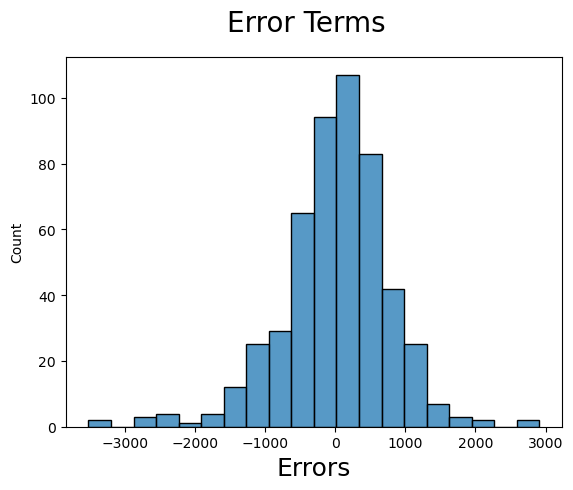

In [25]:
y_train_pred = lr_dec_nov_jul_feb_apr_jun_may_mar_fall.predict(X_train_dec_nov_jul_feb_apr_jun_may_mar_fall)

# Plot the histogram of the error terms
fig = plt.figure()
sns.histplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18) 
plt.show()

<Axes: >

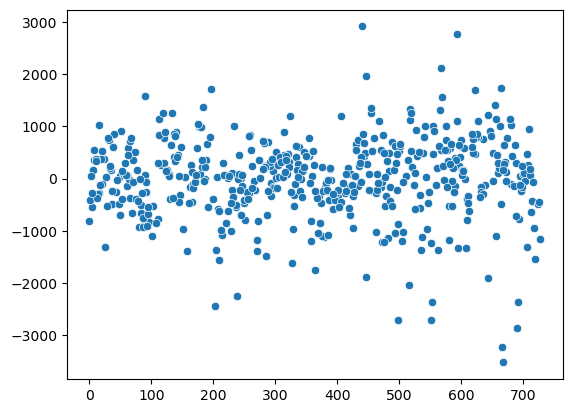

In [26]:
sns.scatterplot(y_train - y_train_pred)
plt.show()

## Prediction using the model built

In [27]:
y_test = bike_test.pop('cnt')

In [28]:
### standardizing the train data
bike_test.shape


bike_test[cols_to_be_scaled] = min_max_scaler.transform(bike_test[cols_to_be_scaled])
bike_test[cols_to_be_scaled].head()

#dropping the columns that are dropped during training
bike_test_dropped = sm.add_constant(bike_test.drop(cols_to_be_dropped, axis = 1))
y_test_pred = lr_dec_nov_jul_feb_apr_jun_may_mar_fall.predict(bike_test_dropped)

y_test.head()
y_test_pred.head()

(220, 23)

,atemp,hum,windspeed
184,0.769660,0.657364,0.084219
535,0.842587,0.610133,0.153728
299,0.496145,0.837699,0.334206
221,0.795343,0.437098,0.339570
152,0.741471,0.314298,0.537414


184    6043
535    6211
299    2659
221    4780
152    4968
Name: cnt, dtype: int64

184    3258.173427
535    7881.628857
299    3744.571297
221    5338.260685
152    5340.386323
dtype: float64

### Model Evaluation

Text(0.5, 0.98, 'y_test vs y_pred')

Text(0.5, 0, 'y_test')

Text(0, 0.5, 'y_pred')

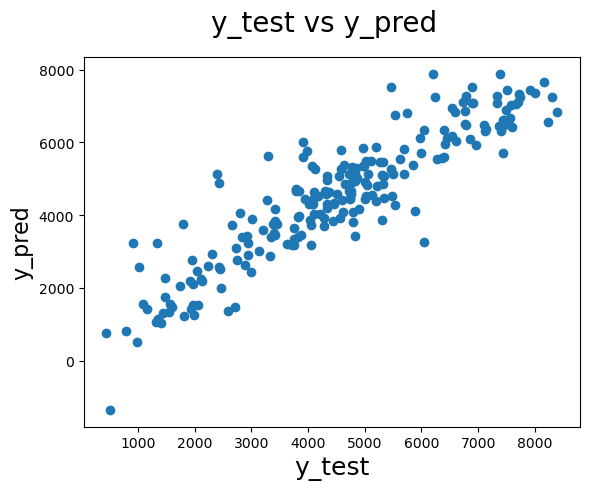

In [29]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

Text(0.5, 0.98, 'Actual and Predicted')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'count')

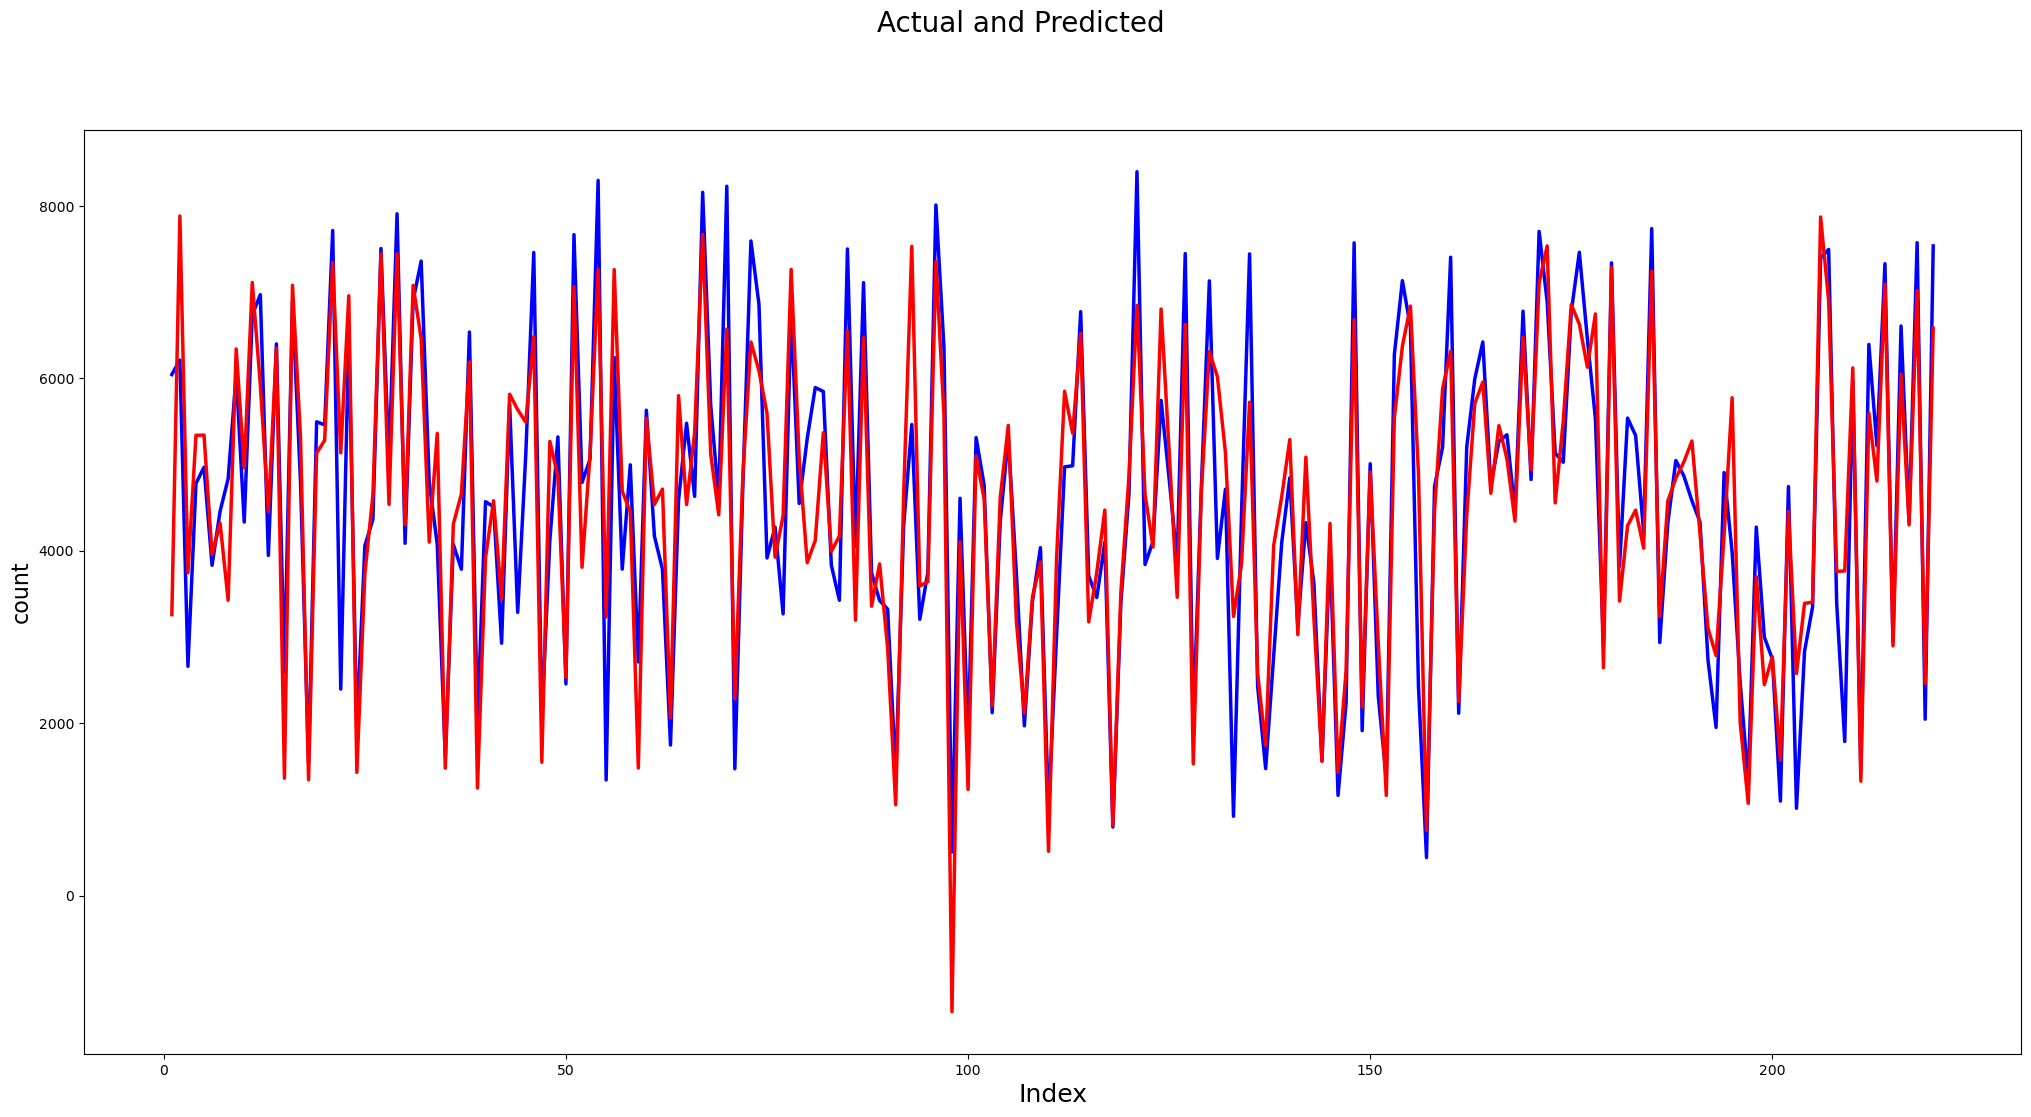

In [30]:
#Actual vs Predicted
c = [i for i in range(1,221,1)]
fig = plt.figure(figsize = (25, 12))
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_test_pred, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('count', fontsize=16)                               # Y-label

In [31]:
from scipy.stats import skewnorm

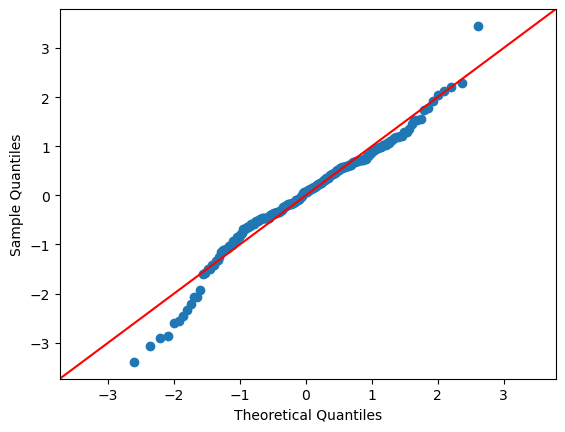

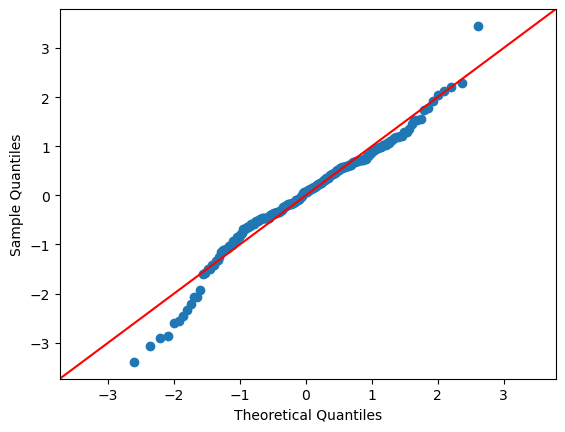

In [32]:
#Q-Q plot on error
sm.qqplot((y_test - y_test_pred),fit=True,line='45')

### R2_score for the test data

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_test_pred)
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.8194247993297941

## Using SkLearn and using automatic feature extraction

In [34]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select = 10)             # running RFE
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))


#Building model using statsmodel, for the detailed statistics
X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()
lm.summary()

## Making prediction using sklearn model

X_test_rfe = bike_test[bike_test.columns[rfe.support_]]
X_test_rfe = sm.add_constant(X_test_rfe)
y_test_pred_rfe = lm.predict(X_test_rfe)

#Compute r2_score
r2_score(y_test, y_test_pred_rfe)

LinearRegression()

[('summer', True, 1),
 ('fall', False, 3),
 ('winter', True, 1),
 ('yr', True, 1),
 ('Feb', False, 10),
 ('Mar', False, 6),
 ('Apr', False, 8),
 ('May', False, 5),
 ('Jun', False, 7),
 ('Jul', False, 9),
 ('Aug', True, 1),
 ('Sep', True, 1),
 ('Oct', False, 4),
 ('Nov', False, 11),
 ('Dec', False, 12),
 ('holiday', True, 1),
 ('weekday', False, 14),
 ('workingday', False, 13),
 ('weather_Clear', False, 2),
 ('weather_light_snow', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1)]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     240.0
Date:                Tue, 09 Jan 2024   Prob (F-statistic):          1.71e-183
Time:                        21:39:44   Log-Likelihood:                -4138.2
No. Observations:                 510   AIC:                             8298.
Df Residuals:                     499   BIC:                             8345.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2403.5132    230.963     10.406      0.000    1949.733    2857.293
summer               856.4742     98.511      8.694      0.000     662.928    1050.021
winter              1256.8523     95.939     13.101      0.000    1068.358    1445.346
yr                  1975.0420     73.263     26.958      0.000    1831.099    2118.984
Aug                  557.7386    145.312      3.838      0.000     272.241     843.237
Sep                 1075.6741    146.021      7.367      0.000     788.783    1362.565
holiday             -744.4312    231.261     -3.219      0.001   -1198.796    -290.066
weather_light_snow -1595.9998    225.512     -7.077      0.000   -2039.071   -1152.929
atemp               5128.0767    203.818     25.160      0.000    4727.630    5528.523
hum                -2521.6282    278.605     -9.051      0.000   -3069.011   -1974.245
windspeed          -1585.2660    230.732     -6.871      0.000   -2038.592   -1131.940
==============================================================================
Omnibus:                       52.532   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.235
Skew:                          -0.561   Prob(JB):                     1.28e-26
Kurtosis:                       5.086   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0.8084769131197941